In [1]:
import numpy
import scipy.special
import matplotlib.pyplot as plt
import math
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = 14, 10

Solução de Schumann

Números adimensionais definidos:


$$y^{*} = \frac{k_2 z}{v_g}$$

$$t^{*} = k_1 \left(t - \frac{ z}{v_g} \right)$$

onde
$$ k_1 =\frac{h A^{'''}} {c_{p,p} \rho_p \left(1 - \varepsilon_{g} \right)} $$
$$ k_2 =\frac{h A^{'''}}{c_{p,g}\rho_g \varepsilon_{g}} $$

A solução é dada por:

$$ \frac{T_p}{T_0} = 1 - e^{-y -z}\sum_{n=0}^{\infty}y^n M_n \left(y z \right ) = e^{-y -z}\sum_{n=1}^{\infty}z^n M_n \left(y z \right )$$

$$ \frac{T_g}{T_0} = 1 - e^{-y -z}\sum_{n=1}^{\infty}y^n M_n \left(y z \right ) = e^{-y -z}\sum_{n=0}^{\infty}z^n M_n \left(y z \right )$$

E 

$$M_0\left(a \right ) = J_0 \left(2 i \sqrt{a} \right ) $$

$$ M_n\left(a \right ) = \frac{d^n M_0 \left(a \right )}{d a^n}$$

$$h_{g} = \frac{h a}{\varepsilon_{g} \rho_{g} c_{p,g}} = \frac{6 h \left ( {1 - \varepsilon_{g}} \right )}{\varepsilon_{g} \rho_{g} c_{p,g} d_{p}}$$

$$h_{p} = \frac{h a}{\left ( {1 - \varepsilon_{g}} \right ) \rho_{p} c_{p,p}} = \frac{6 h}{\rho_{p} c_{p,p} d_{p}}$$



In [10]:
def NusseltDeenEtAl(Rep,  Prandtl, voidage): 
# Particle Nusselt Number(Deen correlation 
# INPUT
#  Rep Scalar number for the particle Reynolds number
#  Prandtl Scalar number for the Prandtl number
#  voidage  Scalar number for bed voidage

# OUTPUT
#  Nup  Scalar number for Nusselt number
    PrPowOneThird  = math.pow(Prandtl,0.3333333333)
    Nup = ((7.0 - 10.0 * voidage + 5.0 * voidage * voidage ) 
      * (1.0 + 0.17 * math.pow(Rep,0.2) * PrPowOneThird )
      + ( 1.33 - 2.31 * voidage + 1.16 * voidage * voidage )  * math.pow(Rep,0.7)
      * PrPowOneThird)
    return Nup

def NusseltGunn(Re, Pr, alpha_f):
#* Gunn (1978) correlation 


# Gunn1978 - Function to calculate the Nusselt (or Sherwood) number for the heat 
# (or mass) transfer using the Gunn (1978) correlation for dense flow of spherical particles.
# parameters:
# Re = Reynolds number based on particle diameter and relative velocity
# Pr = Prandtl number based on fluid properties (or Schmidt number for mass transfer)
# alpha_f = fluid volume (void) fraction
#
# returns:
# Nu = Gunn (1978) Nusselt (or Sherwood) number

# references:
# GUNN, D.; Transfer of Heat or Mass to Particles in Fixed and Fluidized Beds, 
# International Journal of Heat and Mass Transfer, volume 21, issue 4, pages 467-476, 1978.
# 

    Nu = (7.0 - 10.0 * alpha_f + 5.0 * alpha_f * alpha_f) * (1.0 + 0.7 * numpy.power(Re, 0.2) * numpy.power(Pr, 0.3333333333)) + \
    (1.33 - 2.4 * alpha_f + 1.2 * alpha_f * alpha_f) * numpy.power(Re, 0.7) * numpy.power(Pr, 0.3333333333)

    return Nu;

def packedBedTrnsMn(a,n):

# calculation of  parameters required for Schumann solution

    nMax = 30

    result = 0
    for i in range(n,nMax+1):
        piProduct = 1
        for j in range(0,n):
            piProduct = piProduct * (i-j)
                 
        result =  result + a**(i-n) * piProduct / (numpy.math.factorial(i))**2
    
    return(result)


def packedBedTrnsMnSum(y, z, nStart):
# calculation of summation bessel function required for Schumann solution
# INPUT
#   t  ...vector containing the dimensionless time
#   z  ...vector containing the dimentionless length
# OUTPUT
#   result    ...vector containing intermediate results of the Schumann solution

    nMax = 30

    a = y * z   
    result = 0
    for n in range (nStart,nMax+1):        
        result = result + z**(n) * packedBedTrnsMn(a,n)
    
    return(result)



def packedBedTrnsTemperatures(t, z):
#classical solution of Schumann
# INPUT
#   t         ...vector containing the dimensionless time
#  z         ...vector containing the dimentionless length
# OUTPUT
#   TgStar    ...vector of dimensionless gas temperature along the bed 
#   TpStar    ...vector of dimensionless particle temperature along the bed 

    TgStar =  1 -  numpy.exp(-z-t) * packedBedTrnsMnSum(t, z, 1) 

    TpStar = 1 - numpy.exp(-z-t) * packedBedTrnsMnSum(t, z, 0)
      
    return([TgStar, TpStar])


        

In [15]:
# loading the digitized data

#file = open('T_line_caseAverRadius2.csv', mode='r')
#file = open('T_line_caseAverRadiusreallysmall.csv', mode='r')
#file = open('T_alpha_7_keeping_heat_conductivity.csv', mode='r')
#file = open('Temperature_1d_alpha7-conductivity.csv', mode='r')
#file = open('Temperature_1d_alpha7-conductivity-01.csv', mode='r')
file = open('1-d-case-courant-0,2.csv.csv', mode='r')



data = file.read()
file.close()

number_timesteps = data.count('Timestep')
block_size = data.count('\n') // number_timesteps
data = data.split('\n')
print('number of time steps = {0:d}'.format(number_timesteps))
print('data block size = {0:d}'.format(block_size))

temperature = numpy.zeros((number_timesteps, block_size - 3), dtype=numpy.float64)
num_time = numpy.zeros((number_timesteps), dtype=numpy.float64)
num_y = None

for step in range(number_timesteps):
    block = data[step * block_size : (step + 1) * block_size]
    num_time[step] = float(block[1].split(',')[1])
    temperature[step] = numpy.loadtxt(block, dtype=numpy.float64, delimiter=',', skiprows=3, usecols=[4])
    if step == 0:
        num_y = numpy.loadtxt(block, dtype=numpy.float64, delimiter=',', skiprows=3, usecols=[1])

print(temperature[0][0])

print(num_y.shape, temperature[8].shape, num_time[8])
print(num_time.shape, temperature[:, -1].shape, num_y[-1])
print(num_time.shape, temperature[:, -1].shape, num_y[0])


number of time steps = 100
data block size = 54
476.48
(51,) (51,) 0.089972
(100,) (100,) 0.5
(100,) (100,) 0.0


In [16]:
# fluid properties
rho_g = 1000.00 # [kg/m³] fluid density [kg/m^3]
mu_g = 0.001 # [Pa·s]  dynamic viscosity of fluid 
nu_g = mu_g/rho_g  # [kg/(m.s)] kinematic viscosity of fluid 
c_pg = 3000.0 # [J/kg·K] fluid heat capacity [J/(kg.K)]
#c_pg = 4187.0 # [J/kg·K] fluid heat capacity [J/(kg.K)]
T_gi = 500.0 # [K] inlet fluid temperature [K]
T_g0 = 300.0 # [K] initial fluid temperature [K]
#k_g = 0.5  # [J/(m.K)] fluid conductivity 
k_g = 0.1  # [J/(m.K)] fluid conductivity 
Pr_g = c_pg*mu_g/k_g # [ ] Prandtl number 
print(Pr_g)

#particle properties
d_p = 0.001# [m] particle diameter [m]
rho_p = 5000.0 # [kg/m³] density of particle[kg/m^3]
c_pp = 500.0 # [J/kg·K] particle heat capacity [J/(kg.K)]
T_p0 = T_g0 # [K] initial particle temperature
k_p = 0.5  # [J/(m.K)] particle conductivity 
#k_p = 0.025  # [J/(m.K)] particle conductivity 
q_dot = 0.0 # [W/m³]
q_dot_spec = 0.0 #[kJ/(kg.s)] specific heat source 

#Mesh size
l_mesh = 10.0/1000.0 #m
#num_y = num_y + (l_mesh/2.0)
print(num_y)
#operating conditions
U_s = 0.94 # [m/s] superficial velocity

#epsilon_g = 1-0.574 # gas volume fraction [dimensionless][ ] 
epsilon_g = 1-0.574 # gas volume fraction [dimensionless][ ] 
U = U_s/ epsilon_g   # [m/s] this is the TRUE gas velocity, not superficial [m/s]
#h = 1.0 # [W/m²·K]

courant = U*0.001/l_mesh
print("courant = ", courant)

30.0
[ 0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49  0.5 ]
courant =  0.2206572769953051


In [17]:
Rep = d_p * U / nu_g #Re of particle using TRUE velocity
Re_sup = d_p * U_s / nu_g #Re of particle using superficial velocity
                  
Nu_gunn = NusseltGunn(Re_sup, Pr_g, epsilon_g)
print("epsilon = ", epsilon_g)
print("Pr = ", Pr_g)
print("Re = ", Rep)
#print("Nup = ", Nup)
print("Nup_sup = ", Nu_gunn)
print("Peclet number = ", Rep * Pr_g)


#h = k_g * Nup / d_p;
h = k_g * Nu_gunn / d_p;

h_g = (6.0 * h * (1.0 - epsilon_g)) / (epsilon_g * rho_g * c_pg * d_p)
h_p = (6.0 * h) / (rho_p * c_pp * d_p)

hStar = h_g/h_p

print("h_g = ", h_g)
print("h_p = ", h_p)
hpg = h_p + h_g
Biot = h*d_p/k_p

print("Biot = ", Biot )

epsilon =  0.42600000000000005
Pr =  30.0
Re =  2206.572769953051
Nup_sup =  231.643906275
Peclet number =  66197.18309859153
h_g =  62.4242263859
h_p =  55.594537506
Biot =  46.328781255


T inicial =  476.48


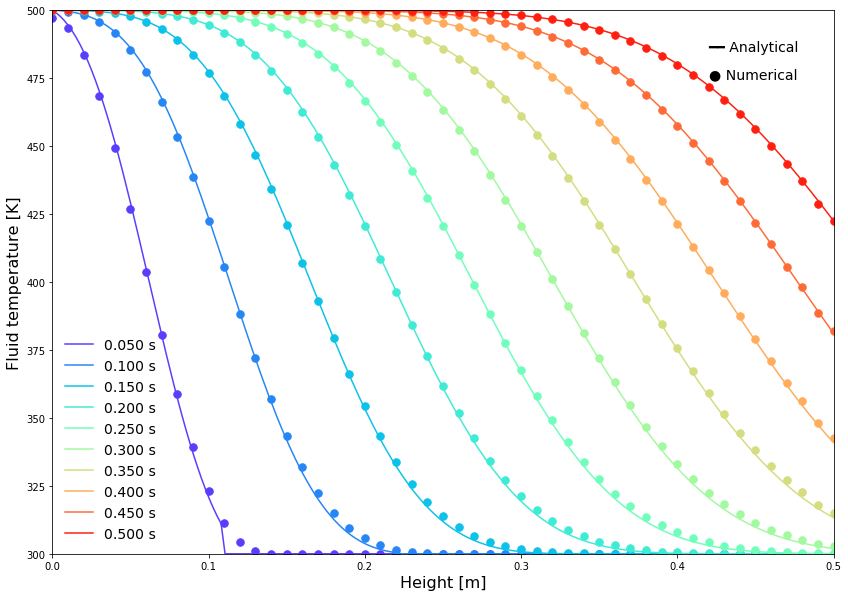

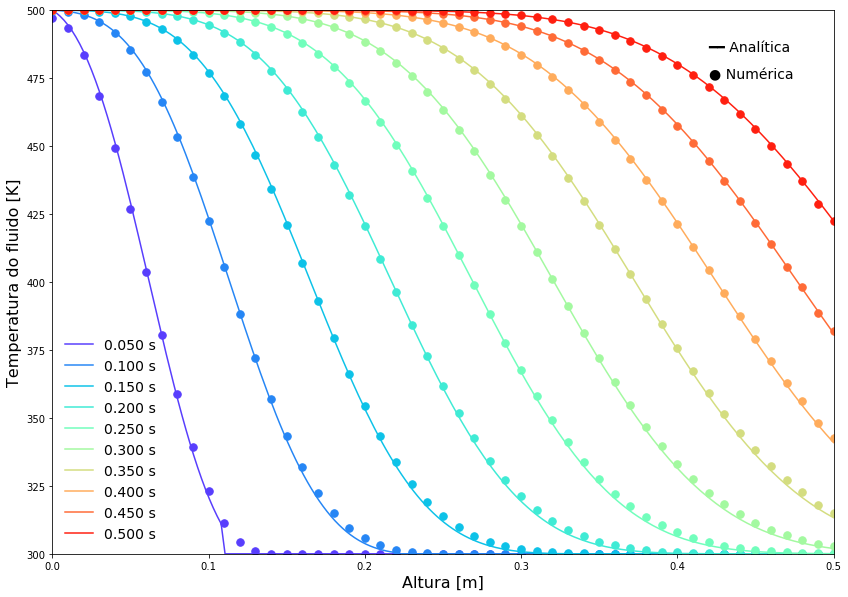

In [25]:
# Fluid temperature x height for each time

print("T inicial = ", temperature[0][0])
i = 4
inc = 5

cmap = plt.get_cmap('rainbow')
y = numpy.linspace(0.0, 0.5, 200)

for time in num_time[i:50:inc]:
#for time in numpy.linspace(0,0.4,20):
    
    zStar = (y * h_g / U)

    tStart = time*h_p - (y/U)*h_p

    TgStart = packedBedTrnsTemperatures(tStart,zStar )[0]

    Tg = TgStart*(T_gi-T_g0) + T_g0

    for index in numpy.where(tStart < 0.0):
        Tg[index] = T_g0
  
    plt.plot(y, Tg, color = cmap(i*5), label = "{0:.3f} s".format(time))
    plt.plot(num_y, temperature[i], marker = 'o', markersize = 7.5, linestyle = 'None', color = cmap(i*5))
    i = i + inc
    

plt.ylim(300, 500)     
plt.xlim(0, 0.5) 

plt.legend(fontsize=14, loc='lower left', frameon=False)
plt.ylabel('Fluid temperature [K]', fontsize=16)
plt.xlabel('Height [m]', fontsize=16)
plt.annotate('━━ Analytical',xy=(0.420, 485), fontsize=14)
plt.annotate('● Numerical', xy=(0.420, 475), fontsize=14)
plt.savefig('gasversusposition.png')
plt.show()

i = 4
inc = 5

cmap = plt.get_cmap('rainbow')
y = numpy.linspace(0.0, 0.5, 200)

for time in num_time[i:50:inc]:
#for time in numpy.linspace(0,0.4,20):
    
    zStar = (y * h_g / U)

    tStart = time*h_p - (y/U)*h_p

    TgStart = packedBedTrnsTemperatures(tStart,zStar )[0]

    Tg = TgStart*(T_gi-T_g0) + T_g0

    for index in numpy.where(tStart < 0.0):
        Tg[index] = T_g0
  
    plt.plot(y, Tg, color = cmap(i*5), label = "{0:.3f} s".format(time))
    plt.plot(num_y, temperature[i], marker = 'o', markersize = 7.5, linestyle = 'None', color = cmap(i*5))
    i = i + inc
    

plt.ylim(300, 500)     
plt.xlim(0, 0.5) 

plt.legend(fontsize=14, loc='lower left', frameon=False)
plt.ylabel('Temperatura do fluido [K]', fontsize=16)
plt.xlabel('Altura [m]', fontsize=16)
plt.annotate('━━ Analítica',xy=(0.420, 485), fontsize=14)
plt.annotate('● Numérica', xy=(0.420, 475), fontsize=14)
plt.savefig('gasversuspositionPortugues.png')
plt.show()



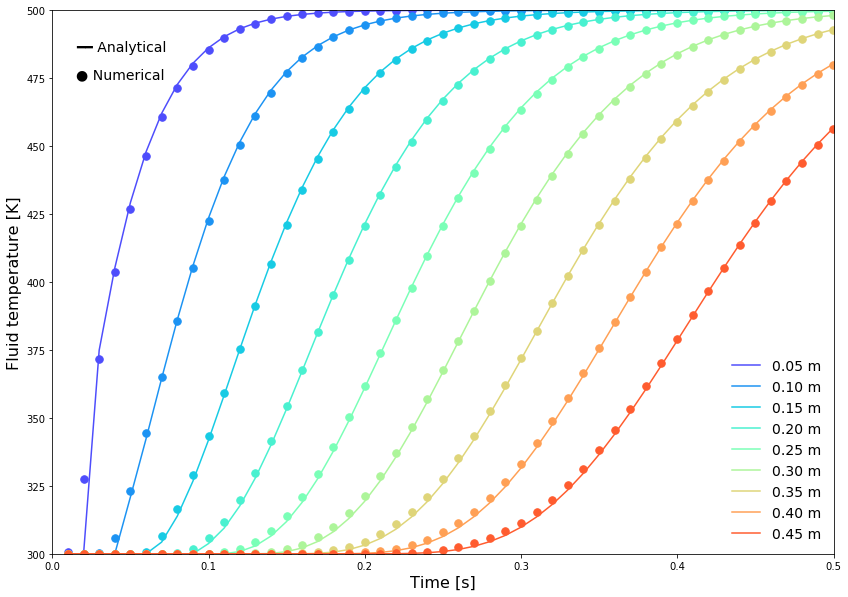

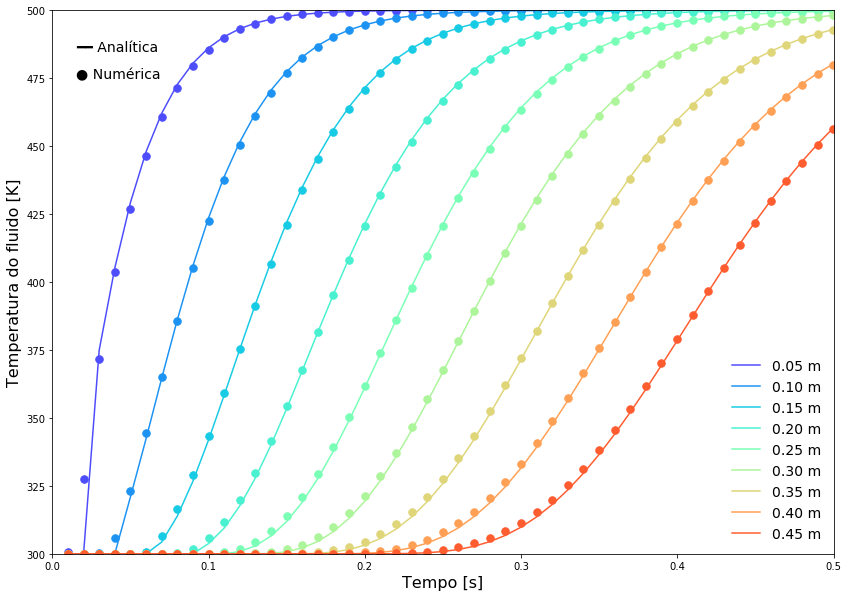

In [27]:
# Fluid temperature x time for each height

i=5
inc = 5

cmap = plt.get_cmap('rainbow')

for y in num_y[i:-1:inc]:
    zStar = (y * h_g / U)  
    tStar = num_time*h_p - (y/U)*h_p
    TgStar = packedBedTrnsTemperatures(tStar,zStar )[0]
    
    Tg = TgStar*(T_gi-T_g0) + T_g0
    for index in numpy.where(tStar < 0.0):
        Tg[index] = T_g0

    plt.plot(num_time, Tg, color = cmap(i*5), label = "{0:.2f} m".format(y) )
    
    plt.plot(num_time, (temperature[:,i]), marker = 'o', markersize = 7.5,  linestyle = 'None', color = cmap(i*5))
    i = i+inc
plt.xlim(0, 0.5)     
plt.ylim(300, 500) 
#plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True)
plt.legend(fontsize=14, loc='lower right', frameon=False)
plt.ylabel('Fluid temperature [K]', fontsize=16)
plt.xlabel('Time [s]', fontsize=16)
plt.annotate('━━ Analytical',xy=(0.015, 485), fontsize=14)
plt.annotate('● Numerical', xy=(0.015, 475), fontsize=14)
plt.savefig('gasversustime.png')
plt.show()


i=5
inc = 5

cmap = plt.get_cmap('rainbow')

for y in num_y[i:-1:inc]:
    zStar = (y * h_g / U)  
    tStar = num_time*h_p - (y/U)*h_p
    TgStar = packedBedTrnsTemperatures(tStar,zStar )[0]
    
    Tg = TgStar*(T_gi-T_g0) + T_g0
    for index in numpy.where(tStar < 0.0):
        Tg[index] = T_g0

    plt.plot(num_time, Tg, color = cmap(i*5), label = "{0:.2f} m".format(y) )
    
    plt.plot(num_time, (temperature[:,i]), marker = 'o', markersize = 7.5,  linestyle = 'None', color = cmap(i*5))
    i = i+inc
plt.xlim(0, 0.5)     
plt.ylim(300, 500) 
#plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True)
plt.legend(fontsize=14, loc='lower right', frameon=False)
plt.ylabel('Temperatura do fluido [K]', fontsize=16)
plt.xlabel('Tempo [s]', fontsize=16)
plt.annotate('━━ Analítica',xy=(0.015, 485), fontsize=14)
plt.annotate('● Numérica', xy=(0.015, 475), fontsize=14)
plt.savefig('gasversustimePortuguese.png')
plt.show()


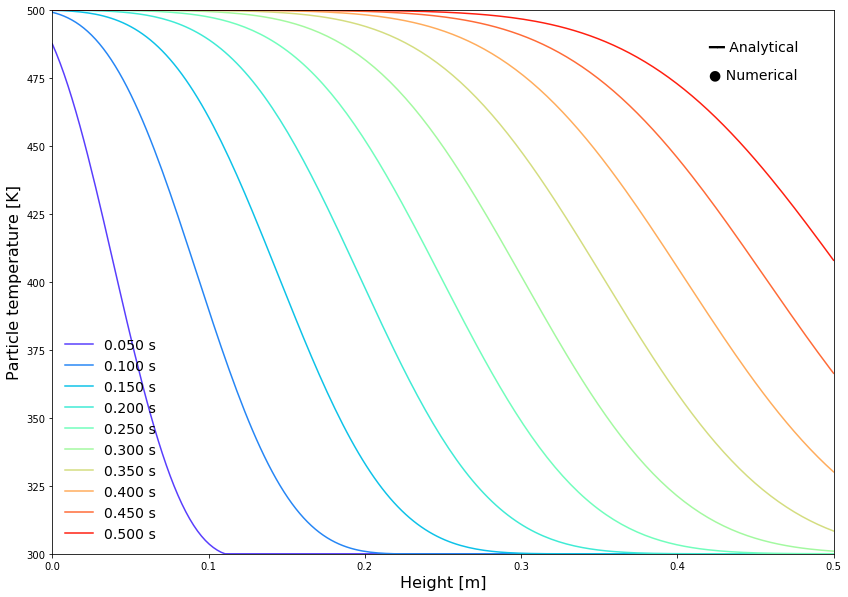

In [28]:
# Particle temperature x height for each time

i = 4
inc = 5

cmap = plt.get_cmap('rainbow')
y = numpy.linspace(0.0, 0.5, 200)

for time in num_time[i:50:inc]:
#for time in numpy.linspace(0,0.4,20):
    
    zStar = (y * h_g / U)

    tStart = time*h_p - (y/U)*h_p

    TpStart = packedBedTrnsTemperatures(tStart,zStar )[1]

    Tp = TpStart*(T_gi-T_g0) + T_g0

    for index in numpy.where(tStart < 0.0):
        Tp[index] = T_g0
  
    plt.plot(y, Tp, color = cmap(i*5), label = "{0:.3f} s".format(time))
    #plt.plot(num_y, temperature[i], marker = 'o', markersize = 7.5, linestyle = 'None', color = cmap(i*5))
    i = i + inc
    

plt.ylim(300, 500)     
plt.xlim(0, 0.5) 

plt.legend(fontsize=14, loc='lower left', frameon=False)
plt.ylabel('Particle temperature [K]', fontsize=16)
plt.xlabel('Height [m]', fontsize=16)
plt.annotate('━━ Analytical',xy=(0.420, 485), fontsize=14)
plt.annotate('● Numerical', xy=(0.420, 475), fontsize=14)
plt.savefig('particleTversusposition.png')
plt.show()


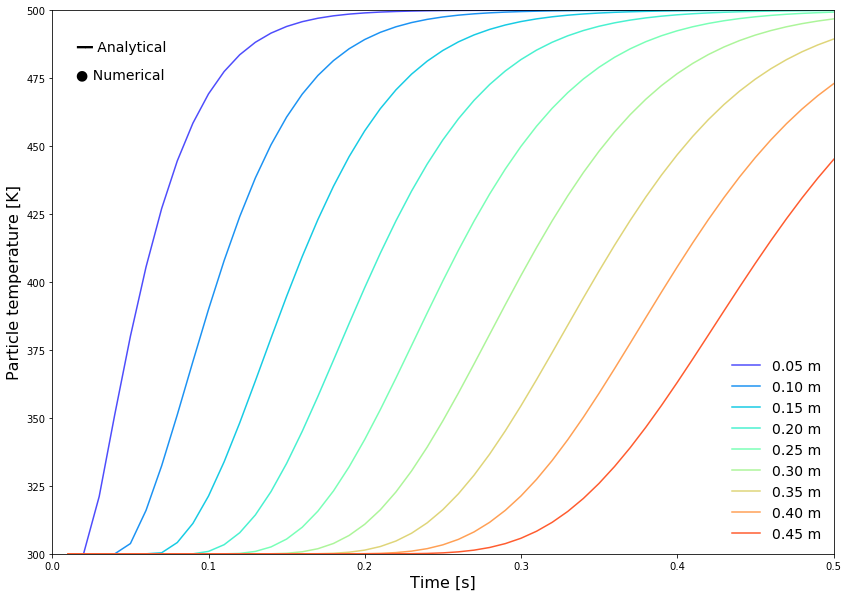

In [29]:
# Particle temperature x time for each height

i=5
inc = 5

cmap = plt.get_cmap('rainbow')

for y in num_y[i:-1:inc]:
    zStar = (y * h_g / U)  
    tStar = num_time*h_p - (y/U)*h_p
    TpStar = packedBedTrnsTemperatures(tStar,zStar )[1]
    
    Tp = TpStar*(T_gi-T_g0) + T_g0
    for index in numpy.where(tStar < 0.0):
        Tp[index] = T_g0

    plt.plot(num_time, Tp, color = cmap(i*5), label = "{0:.2f} m".format(y) )
    
    #plt.plot(num_time, (temperature[:,i]), marker = 'o', markersize = 7.5,  linestyle = 'None', color = cmap(i*5))
    i = i+inc
plt.xlim(0, 0.5)     
plt.ylim(300, 500) 
#plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True)
plt.legend(fontsize=14, loc='lower right', frameon=False)
plt.ylabel('Particle temperature [K]', fontsize=16)
plt.xlabel('Time [s]', fontsize=16)
plt.annotate('━━ Analytical',xy=(0.015, 485), fontsize=14)
plt.annotate('● Numerical', xy=(0.015, 475), fontsize=14)
plt.savefig('particleTversustime.png')
plt.show()